In [1]:
import joblib

joblib.parallel_config(backend="multiprocessing")

import joblib._store_backends
import sys

import random
import numpy as np
import torch
import openml
import types

import random
from sklearn.model_selection import train_test_split
from simple_model import ConformalRankingPredictor, ConformalPredictor, ClassifierModel
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
)


master_seed = 1
rng = random.Random(master_seed)
mccv_split_seed = rng.randint(0, 2**32 - 1)
clf_seed = rng.randint(0, 2**32 - 1)

random.seed(clf_seed)
np.random.seed(clf_seed)
torch.manual_seed(clf_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(clf_seed)
    torch.cuda.manual_seed_all(clf_seed)

dataset = openml.datasets.get_dataset(187)
X, y, _, _ = dataset.get_data(
    target=dataset.default_target_attribute, dataset_format="dataframe"
)

# Automatically identify categorical and numerical columns
categorical_features = X.select_dtypes(
    include=["object", "category"]
).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_classes = len(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=mccv_split_seed
)

# Encode labels
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Preprocessing for numerical data: Impute missing values, then scale
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# Preprocessing for categorical data: Impute missing values, then one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

X_train = preprocessor.fit_transform(X_train)

model = ClassifierModel(
    input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes
)
predictor_clf = ConformalPredictor(model=model, alpha=0.05)
predictor_rnk = ConformalRankingPredictor(
    num_classes=num_classes, alpha=0.05, hidden_dim=16
)

if not isinstance(X_train, np.ndarray):
    X_train = X_train.toarray()
if not isinstance(y_train, np.ndarray):
    y_train = y_train.toarray()

predictor_clf.fit(
    X_train,
    y_train,
    cal_size=0.2,
    random_state=clf_seed,
)


predictor_rnk.fit(
    X_train,
    y_train,
    cal_size=0.2,
    random_state=clf_seed,
)


/home/jonas/Documents/Research/dyad_ranking/torch_plnet/.venv/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


In [2]:

X_test = preprocessor.transform(X_test)

# X_test = X_test.to_numpy()
if not isinstance(X_test, np.ndarray):
    X_test = X_test.toarray()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.toarray()

y_pred_crisp_clf = predictor_clf.model.predict(X_test)
y_pred_set_clf = predictor_clf.predict_set(X_test)

y_pred_crisp_rnk = predictor_rnk.model.predict(X_test)
y_pred_set_rnk = predictor_rnk.predict_set(X_test)


# Classifcation metrics of crisp (point) prediction
score_f1_clf = f1_score(y_test, y_pred_crisp_clf, average="macro")
score_acc_clf = accuracy_score(y_test, y_pred_crisp_clf)
score_bacc_clf = balanced_accuracy_score(y_test, y_pred_crisp_clf)
score_f1_rnk = f1_score(y_test, y_pred_crisp_rnk, average="macro")
score_acc_rnk = accuracy_score(y_test, y_pred_crisp_rnk)
score_bacc_rnk = balanced_accuracy_score(y_test, y_pred_crisp_rnk)
# score_roc_auc = roc_auc_score(
#     y_test, y_pred_crisp, average="macro", multi_class="ovr"
# )

# Conformal prediction metrics
hits_clf = [y_test[i] in y_pred_set_clf[i] for i in range(len(y_test))]
lens_clf = [len(y_pred_set_clf[i]) for i in range(len(y_test))]
hits_rnk = [y_test[i] in y_pred_set_rnk[i] for i in range(len(y_test))]
lens_rnk = [len(y_pred_set_rnk[i]) for i in range(len(y_test))]

coverage_mean_clf = np.mean(hits_clf)
coverage_std_clf = np.std(hits_clf)
efficiency_mean_clf = np.mean(lens_clf)
efficiency_std_clf = np.std(lens_clf)

coverage_mean_rnk = np.mean(hits_rnk)
coverage_std_rnk = np.std(hits_rnk)
efficiency_mean_rnk = np.mean(lens_rnk)
efficiency_std_rnk = np.std(lens_rnk)

print("Clf: ", coverage_mean_clf, efficiency_mean_clf)
print("Rnk: ", coverage_mean_rnk, efficiency_mean_rnk)

Clf:  1.0 1.0
Rnk:  0.9722222222222222 1.2222222222222223


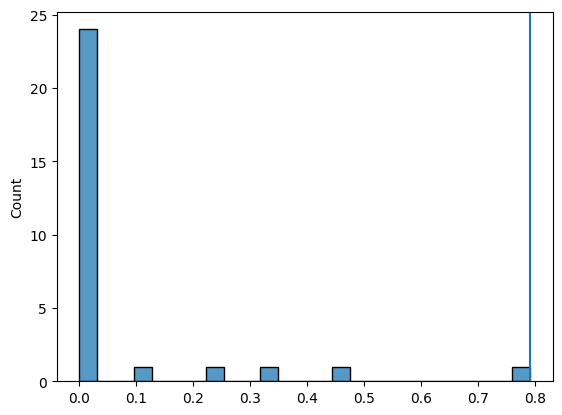

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.histplot(x=predictor_clf.scores, ax=ax, bins=25)
ax.axvline(x=predictor_clf.threshold)

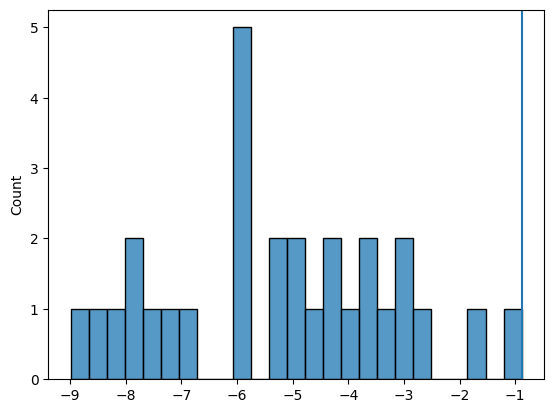

In [4]:
fig, ax = plt.subplots()

sns.histplot(x=predictor_rnk.scores.ravel(), ax=ax, bins=25)
ax.axvline(x=predictor_rnk.threshold)
print()

In [5]:
good_example = X_test[1].reshape(1,-1)

pred_set_clf = predictor_clf.predict_set(good_example)
pred_set_rnk = predictor_rnk.predict_set(good_example)
print("pred set clf", pred_set_clf)
print("pred set rnk", pred_set_rnk)
print("true label", y_test[1])

pred set clf [array([0])]
pred set rnk [array([0])]
true label 0


In [6]:
predictor_clf.model.predict_proba(good_example)

array([[9.9949014e-01, 1.6332378e-04, 3.4654079e-04]], dtype=float32)

In [7]:
predictor_clf.threshold

0.7914753

In [8]:
1 - predictor_clf.model.predict_proba(good_example)

array([[5.0985813e-04, 9.9983668e-01, 9.9965346e-01]], dtype=float32)

In [9]:
predictor_rnk.model.predict_class_skills(good_example)


array([[ 3.438745 , -3.6703255, -4.8003135]], dtype=float32)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Prepare CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (for ResNet)
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # CIFAR-10 normalization
])


# Step 1: Prepare CIFAR-10 Dataset
transform_otf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to 224x224 (for ResNet)
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # CIFAR-10 normalization
])


train_dataset_orig = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataset = Subset(train_dataset_orig, range(0,64))
cal_dataset = Subset(train_dataset_orig, range(64,1024))

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Step 2: Modify ResNet18 for CIFAR-10 (10 classes)
model = models.resnet18(pretrained=False)  # Do not load pretrained weights
model.fc = nn.Linear(model.fc.in_features, 10)  # Modify the final layer for CIFAR-10 (10 classes)

# Step 3: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5  # You can adjust the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Step 5: Fine-tuned model is ready

# Step 6: Wrap the model for MAPIE (similar to earlier)
class TorchClassifierWrapper:
    def __init__(self, model, transform=None, device=None):
        self.model = model
        self.transform = transform
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.classes_ = np.arange(10)  # CIFAR-10 has 10 classes
        # self.n_features_in_ = None  # Set in fit()

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        # self.n_features_in_ = X.shape[1:]  # Image shape, e.g., (3, 224, 224)
        return self

    def predict_proba(self, X):
        from sklearn.utils.validation import check_is_fitted
        check_is_fitted(self, ["classes_"])
        
        self.model.eval()
        
        tensors = torch.stack([transform_otf(image) for image in X])

        with torch.no_grad():
            # Transform and move data to device
            # if isinstance(X, np.ndarray):
            #     X = torch.tensor(X).float()
            X_tensor = tensors.to(self.device)
            logits = self.model(X_tensor)
            probabilities = torch.nn.functional.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    def __sklearn_is_fitted__(self):
        return True

    # def get_params(self, deep=True):
    #     return {"model": self.model, "transform": self.transform, "device": self.device}

    # def set_params(self, **params):
    #     for param, value in params.items():
    #         setattr(self, param, value)
    #     return self

# Wrap the model
wrapped_model = TorchClassifierWrapper(model=model, transform=transform)

# Step 7: Use MAPIE for conformal predictions
from mapie.classification import MapieClassifier

# Create a dummy fit call (MAPIE needs this to work)
X_cal, y_cal = X_test, y_test

wrapped_model.fit(X_cal, y_cal)  # Fit the model wrapper
mapie = MapieClassifier(estimator=wrapped_model, method="aps", cv="prefit")
mapie.fit(X_cal, y_cal)  # Fit MAPIE with dummy data




Files already downloaded and verified
Files already downloaded and verified


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/5], Loss: 3.0173, Accuracy: 15.62%
Epoch [2/5], Loss: 2.3647, Accuracy: 17.19%
Epoch [3/5], Loss: 1.9298, Accuracy: 35.94%
Epoch [4/5], Loss: 1.9485, Accuracy: 28.12%
Epoch [5/5], Loss: 1.7382, Accuracy: 34.38%


MapieClassifier(cv='prefit',
                estimator=<__main__.TorchClassifierWrapper object at 0x725bdfd43790>,
                method='score')

In [26]:
# Step 8: Make predictions on CIFAR-10 test set

y_pred, y_pred_set = mapie.predict(X_train[:20], alpha=0.1)
print("True values:", y_train[:5])
print("Predicted labels:", y_pred[:5])
print("Prediction sets:", y_pred_set[:5])
    # break  # Remove to process the entire dataset

True values: [1, 0, 3, 3, 9]
Predicted labels: [3 3 3 0 3]
Prediction sets: [[[ True]
  [ True]
  [ True]
  [ True]
  [False]
  [ True]
  [False]
  [ True]
  [ True]
  [ True]]

 [[False]
  [False]
  [ True]
  [ True]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [False]
  [ True]
  [ True]
  [False]
  [ True]
  [False]
  [False]
  [False]
  [False]]

 [[ True]
  [ True]
  [ True]
  [ True]
  [False]
  [ True]
  [False]
  [False]
  [ True]
  [ True]]]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Step 1: Prepare CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (for ResNet)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # CIFAR-10 normalization
])


# Step 1: Prepare CIFAR-10 Dataset
transform_otf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to 224x224 (for ResNet)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # CIFAR-10 normalization
])

train_dataset_orig = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [4]:
train_dataset_orig[0][0]

tensor([[[0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         [0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         [0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         ...,
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824],
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824],
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         [0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         [0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         ...,
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608],
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608],
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608]],

        [[0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.4039],
         [0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.4039],
         [0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.

In [5]:
X = train_dataset_orig.data
print(transform_otf(X[0]))


tensor([[[0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         [0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         [0.2314, 0.2314, 0.2314,  ..., 0.5804, 0.5804, 0.5804],
         ...,
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824],
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824],
         [0.6941, 0.6941, 0.6941,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         [0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         [0.2431, 0.2431, 0.2431,  ..., 0.4863, 0.4863, 0.4863],
         ...,
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608],
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608],
         [0.5647, 0.5647, 0.5647,  ..., 0.3608, 0.3608, 0.3608]],

        [[0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.4039],
         [0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.4039],
         [0.2471, 0.2471, 0.2471,  ..., 0.4039, 0.4039, 0.

In [13]:
from sklearn.model_selection import train_test_split

X = train_dataset_orig.data
y = train_dataset_orig.targets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=150)

In [14]:

pic = transform_otf(X_train[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3709111..2.7537313].


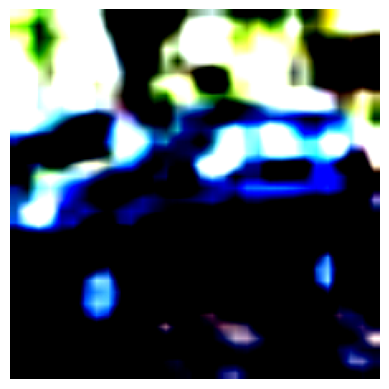

In [15]:
import matplotlib.pyplot as plt
plt.imshow(pic.permute(1, 2, 0))
plt.axis('off')  # Optional: turn off axis
plt.show()

In [2]:
import numpy as np
from mapie.classification import MapieClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import load_wine, load_iris
from sklearn.model_selection import train_test_split
from models.classifier_model import ClassifierModel

# Generate synthetic data
X, y = make_classification(n_classes=10,n_samples=15000, n_features=15, random_state=42,n_informative=5)
# X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/4, shuffle=True)
X_train, X_cal, y_train, y_cal = train_test_split(X_train,y_train,test_size=1/3, shuffle=True)

# Fit MapieClassifiers
clf = ClassifierModel(input_dim=X.shape[1],hidden_dim=16,output_dim=len(np.unique(y)))
clf.fit(X_train, y_train)
# clf = RandomForestClassifier()
# clf.fit(X_train, y_train)
mapie = MapieClassifier(estimator=clf, method="score", cv="prefit")
mapie.fit(X_cal, y_cal)

# Predict with alpha for prediction sets
alpha = 0.05
predictions, prediction_sets = mapie.predict(X_test, alpha=alpha)

plausible_labels = [
    np.where(prediction_set_row)[0].tolist()  # Extract indices where value is True
    for prediction_set_row in prediction_sets
]

print(prediction_sets)
print(plausible_labels)

# Coverage Calculation
coverage = np.mean([
    y_test[i] in plausible_labels[i]
    for i in range(len(y_test))
])

# Efficiency Calculation
efficiency = np.mean([
    len(plausible_labels[i])
    for i in range(len(plausible_labels))
])

print(f"Coverage: {coverage:.2f}")
print(f"Efficiency: {efficiency:.2f}")

[[[ True]
  [False]
  [ True]
  ...
  [False]
  [ True]
  [False]]

 [[ True]
  [False]
  [ True]
  ...
  [False]
  [False]
  [ True]]

 [[False]
  [False]
  [False]
  ...
  [ True]
  [False]
  [ True]]

 ...

 [[ True]
  [False]
  [False]
  ...
  [False]
  [ True]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [ True]]

 [[False]
  [False]
  [False]
  ...
  [ True]
  [False]
  [ True]]]
[[0, 2, 3, 8], [0, 2, 3, 4, 5, 6, 9], [4, 7, 9], [3], [0, 2, 3, 4, 8], [1, 6], [4, 7, 8], [1, 2, 3, 6, 8], [0, 1, 2, 3, 8, 9], [0, 1, 2, 5, 6, 8], [2, 4, 5, 6, 9], [0, 2, 4, 6, 8, 9], [0, 2, 9], [0, 4, 7, 9], [0, 1, 2, 3, 7, 8, 9], [0, 2, 6, 8, 9], [0, 2, 3, 8], [4, 7, 8, 9], [0, 1, 2, 3, 6, 8], [0, 2, 3, 8, 9], [0, 3, 4, 6, 7, 9], [1, 2, 3], [2, 4, 5, 7, 8, 9], [0, 1, 3, 7], [0, 2, 3, 8], [0, 2, 3, 8], [0, 2, 4, 6, 9], [0, 2, 3, 8, 9], [0, 2, 4, 8], [0, 2, 4, 7, 8, 9], [0, 2, 3, 5, 6, 8], [4, 9], [4, 5, 6, 7, 9], [0, 1, 2, 3, 6, 8], [5, 6, 7, 9], [0, 2, 3, 5, 6, 8, 9], [0, 2, 3,

In [9]:
mapie.estimator.gradient_updates

18800